In [3]:
# 1.1 Prerequisites
!pip install transformers datasets pandas scikit-learn torch torchvision torchaudio ipywidgets jupyterlab-widgets 'accelerate>=0.26.0' --quiet

In [1]:
!pip uninstall torch torchvision torchaudio -y --quiet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
!pip install transformers datasets pandas scikit-learn ipywidgets accelerate>=0.26.0 gradio --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import os
import pandas as pd
import transformers
import torch
import joblib
import gradio as gr
from datasets import concatenate_datasets, load_dataset, Dataset, DatasetDict
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
!pip freeze > requirements.txt

In [3]:
dataset1 = load_dataset("Tom158/Nutritional-LLama")
# Additional dataset
dataset2 = load_dataset("sridhar52/Augmented_Meal_Planner_data")

# Rename columns
dataset2 = dataset2.rename_column('input', 'User')
dataset2 = dataset2.rename_column('output', 'Nutritionist')

# Concatenate datasets
concat_dataset = concatenate_datasets([dataset1['train'], dataset2['train']])

dataset = DatasetDict({'train': concat_dataset})

# unwanted_words = ["cancer", "diabetes"]
# filtered_dataset = dataset.filter(lambda x: not any(word in x["Nutritionist"].lower() for word in unwanted_words))

# Split the train split into 90% train, 10% val
split_dataset = dataset['train'].train_test_split(test_size = 0.1, seed = 42)
print(split_dataset)

# Possible issue due to N/A values on combined datasets and also N/A values

DatasetDict({
    train: Dataset({
        features: ['System', 'User', 'Nutritionist', 'text'],
        num_rows: 5389
    })
    test: Dataset({
        features: ['System', 'User', 'Nutritionist', 'text'],
        num_rows: 599
    })
})


In [4]:
# 1.3 Step 2: Tokenize the Text
# Note: We have used distilbert-base-uncased tokenizer in Tutorial_1
model_name = "gpt2"

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load the model (GPT-2 Small)
model = GPT2LMHeadModel.from_pretrained(model_name)

def format_qa(example):
    return {
        "prompt": f"Q: {example["User"]}\nA: {example["Nutritionist"]}"
    }

def tokenize_function(example):
    return tokenizer(example["prompt"])

split_dataset = split_dataset.map(format_qa)
print(split_dataset["train"][0]["prompt"])
tokenized_dataset = split_dataset.map(tokenize_function, batched = True, remove_columns = ["System", "User", "Nutritionist", "text", "prompt"])
print(tokenized_dataset)

Q: What are the best ways to incorporate strips into my diet while taking care of my health, considering I'm going through treatment for cancer?
A: Considering your current situation and the nutritional values of strips, it's great that you're thinking about incorporating them into your diet. Since you have a significant amount of fiber from the strips, it can help support healthy digestion. Given your age and weight, it's essential to prioritize nutrient-dense foods to maintain your overall well-being during cancer treatment. While strips may not be packed with protein or fat, they can still provide some carbohydrates for energy. To make the most of this food item, try pairing them with other fiber-rich foods like fruits, vegetables, or whole grains. Additionally, be mindful of your calorie intake and balance it with other nutrient-dense foods to ensure you're getting enough overall nutrition. Remember to also stay hydrated by drinking plenty of water throughout the day.
DatasetDict({

In [5]:
# 1.4 Step 3: Group Tokens for Language Modeling
block_size = 128

def group_texts(examples):
    concatenated = sum(examples['input_ids'], [])
    concatenated_attention_mask = sum(examples['attention_mask'], [])
    
    total_length = (len(concatenated) // block_size) * block_size
    result = {
        'input_ids': [concatenated[i:i + block_size] for i in range(0, total_length, block_size)],
        'attention_mask': [concatenated_attention_mask[i:i + block_size] for i in range(0, total_length, block_size)]
    }

    result["labels"] = result["input_ids"].copy()
    return result

lm_dataset = tokenized_dataset.map(group_texts, batched = True)
lm_dataset["train"][0]

{'input_ids': [48,
  25,
  1867,
  389,
  262,
  1266,
  2842,
  284,
  19330,
  22670,
  656,
  616,
  5496,
  981,
  2263,
  1337,
  286,
  616,
  1535,
  11,
  6402,
  314,
  1101,
  1016,
  832,
  3513,
  329,
  4890,
  30,
  198,
  32,
  25,
  27662,
  534,
  1459,
  3074,
  290,
  262,
  24000,
  3815,
  286,
  22670,
  11,
  340,
  338,
  1049,
  326,
  345,
  821,
  3612,
  546,
  29927,
  606,
  656,
  534,
  5496,
  13,
  4619,
  345,
  423,
  257,
  2383,
  2033,
  286,
  13608,
  422,
  262,
  22670,
  11,
  340,
  460,
  1037,
  1104,
  5448,
  44639,
  13,
  11259,
  534,
  2479,
  290,
  3463,
  11,
  340,
  338,
  6393,
  284,
  32980,
  27560,
  12,
  67,
  1072,
  9013,
  284,
  5529,
  534,
  4045,
  880,
  12,
  11873,
  1141,
  4890,
  3513,
  13,
  2893,
  22670,
  743,
  407,
  307,
  11856,
  351,
  7532,
  393,
  3735,
  11,
  484,
  460,
  991,
  2148,
  617,
  32328,
  329,
  2568,
  13,
  1675,
  787,
  262,
  749,
  286],
 'attention_mask': [1,
  1,
  1,
  

In [15]:
# Trains the model and selects a GPU if possible
# Some hyperparameters were changed as Google Colab's TPU and GPU
# had expired, so the CPU was utilized with parameters adjusted to
# allow it to train in a reasonable amount of time.

class LoggingEarlyStoppingCallback(transformers.EarlyStoppingCallback):
    def __init__(self, early_stopping_patience, early_stopping_threshold):
        super().__init__(early_stopping_patience=early_stopping_patience, early_stopping_threshold=early_stopping_threshold)
        self.stopped_epoch = None

    def on_train_end(self, args, state, control, **kwargs):
        if state.global_step < state.max_steps:
            # Early stopping occurred
            self.stopped_epoch = int(state.epoch) + 1

# 10. Optional: Use early stopping
early_stopping_callback = LoggingEarlyStoppingCallback(early_stopping_patience = 3, early_stopping_threshold = 0.01)
# early_stopping_callback = transformers.EarlyStoppingCallback(
#      early_stopping_patience = 3,
#      early_stopping_threshold = 0.01
# )
# trainer.add_callback(early_stopping_callback)

# 1. Leverage mixed precision training
training_args = TrainingArguments(
    output_dir = "./qa_gpt2",
    
    # 2. Aligned evaluation and saving strategy
    eval_strategy = "steps", # Evaluate at specific steps
    eval_steps = 100, # Evaluate every 100 steps
    save_strategy = "steps", # Does not allow equality to "epoch"
    save_steps = 100, # Save every 100 steps
    save_total_limit = 2, # Keep only the 2 most recent checkpoints

    # 3. Increase learning rate and use warmup
    learning_rate = 5e-5, # Higher learning rate
    warmup_ratio = 0.1, # Warm up for first 10% of training

    # 4. Increase batch size
    per_device_train_batch_size = 16, # Increase if your GPU has enough memory
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2, # Simulate larger batch sizes

    # 5. Enable fp16 training (mixed precision)
    fp16 = True, # Enable mixed precision training

    # 6. Early stopping configuration
    load_best_model_at_end = True, # Load the best model when training ends
    metric_for_best_model = "loss", # Use evaluation loss as the metric to track
    greater_is_better = False, # Lower loss is better

    # 7. Other optimizations
    weight_decay = 0.01,
    logging_steps = 50, # Less frequent logging
    report_to = "none",

    # 8. Enable data parallelism if multiple GPUs are available
    dataloader_num_workers = 4, # Use multiple CPU cores for data loading

    # 9. Set number of epochs
    num_train_epochs = 10, # Maintain the original epochs setting
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer = tokenizer, mlm = False
)

# 9. Initialize the Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = lm_dataset["train"],
    eval_dataset = lm_dataset["test"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    callbacks = [early_stopping_callback],
)

# early_stopping_callback = transformers.EarlyStoppingCallback(
#      early_stopping_patience = 3,
#      early_stopping_threshold = 0.01
# )
# trainer.add_callback(early_stopping_callback)

# Start training
trainer.train()

C:\Users\tuand\AppData\Local\Temp\ipykernel_4240\2169167799.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,0.385700,0.758825
200,0.359700,0.780968
300,0.364100,0.785574
400,0.389900,0.745003
500,0.423400,0.726508
600,0.413700,0.732590
700,0.439800,0.714940
800,0.443700,0.711235
900,0.438800,0.710658
1000,0.419000,0.711849


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1000, training_loss=0.41427987098693847, metrics={'train_runtime': 683.5066, 'train_samples_per_second': 64.813, 'train_steps_per_second': 2.019, 'total_flos': 2082105556992000.0, 'train_loss': 0.41427987098693847, 'epoch': 7.194945848375451})

In [7]:
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

('my_model\\tokenizer_config.json',
 'my_model\\special_tokens_map.json',
 'my_model\\vocab.json',
 'my_model\\merges.txt',
 'my_model\\added_tokens.json')

In [5]:
model = GPT2LMHeadModel.from_pretrained("my_model")
tokenizer = GPT2Tokenizer.from_pretrained("my_model")

In [9]:
qa_pipeline = pipeline("text-generation", model = model, tokenizer = tokenizer)

output1 = qa_pipeline("Q: I'm looking to improve my diet by eating more protein. However, I'm allergic to peanut.\nA:", max_new_tokens = 50)
output2 = qa_pipeline("Q: How can I incorporate more cheese into my diet?\nA:", max_new_tokens = 50)
output3 = qa_pipeline("Q: \nA:", max_new_tokens = 50)
output4 = qa_pipeline("Q:  \nA:", max_new_tokens = 50)
output5 = qa_pipeline("Q: I'm allergic to everything, give me a diet plan.\nA:", max_new_tokens = 50)
output6 = qa_pipeline("Q: I am a human being... RAAH KACHOW!\nA:", max_new_tokens = 50)

# 3 unique sentences for generation testing
print(output1[0]["generated_text"])
print(output2[0]["generated_text"])
print(output3[0]["generated_text"])
print(output4[0]["generated_text"])
print(output5[0]["generated_text"])
print(output6[0]["generated_text"])

Device set to use cuda:0


Q: I'm looking to improve my diet by eating more protein. However I'm allergic to peanut.
A: Peanuts can be a great addition to your diet, but as someone who's 59 and diabetic, it's always a good idea to consider your health. As you're 65 and weight 43 kg, the high protein content will fuel your body during this
Q: How can I incorporate more cheese into my diet?
A: As you're looking to gain weight, it might be helpful to focus on adding more calories and carbohydrates to support this goal. Cheese that is also high in protein and fat is a great way to start! Just remember to balance it out with other nutrient
Q: 
A: Based on the input, a high-protein meal plan for gain muscle might include:
- Breakfast: Oats with almond butter and banana
- Lunch: Quinoa salad with chickpeas and greens
- Dinner: Grilled tofu with ste
Q:  
A: I'm designed to assist with meal planning. Please ask a relevant question.Q: Create a snack ideas for someone who is 150 cm tall, weighs 90 lbs, follows a low-carb d

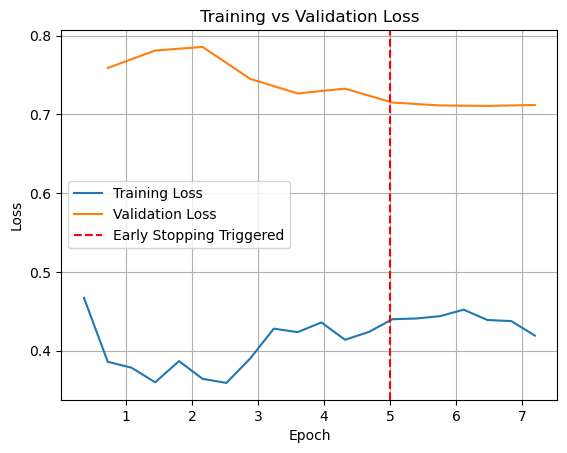

In [16]:
import matplotlib.pyplot as plt

# Convert trainer log history to a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# Filter for epoch-level logs (you may need to adjust this depending on logging strategy)
train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]].groupby("epoch").mean()
val_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss"]].groupby("epoch").mean()

# Reset index to get epoch as a column
train_loss.reset_index(inplace=True)
val_loss.reset_index(inplace=True)

# Plot
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss")

# Optional: add early stopping trigger marker (mocked here, since Hugging Face Trainer doesn't track this directly)
early_stopping_epoch = early_stopping_callback.stopped_epoch
patience = early_stopping_callback.early_stopping_patience
plt.axvline(x=early_stopping_epoch - patience, color="red", linestyle="--", label="Early Stopping Triggered")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define a generation function
def generate_answer(prompt):
    try:
        result = qa_pipeline(prompt, max_new_tokens = 100, do_sample = True, temperature = 0.9)
        result = result[0]['generated_text']

        # Extract answer after "A:"
        if "A:" in result:
            result = result.split("A:", 1)[1].strip()
        else:
            result = result.strip()  # fallback if format breaks

        return result
    except Exception as e:
        return f"[ERROR] {str(e)}"

# Create the Gradio interface
interface = gr.Interface(
    fn=generate_answer,
    inputs=gr.Textbox(lines=2, placeholder="Type a question or prompt...", label="Prompt"),
    outputs="text",
    title="GPT-2 Q&A Generator",
)

interface.launch()